## **Taller 3: Image retrieval**

#Montar Google Drive y extraer el dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ruta_tar = '/content/drive/MyDrive/EAFIT/Semestre3/Visualizacion_de_datos/Talleres/Caltech/256_ObjectCategories.tar'
!tar -xf "$ruta_tar"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Instalar CLIP

In [ ]:
!pip install -q ftfy regex tqdm
!pip install -q git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.3 MB/s eta 0:00:00


In [ ]:
import clip
import torch
from PIL import Image
import os
import random
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 46.6MiB/s]


# Cargar imágenes

In [ ]:
dataset_path = "/content/256_ObjectCategories"
clases = sorted(os.listdir(dataset_path))

imagenes = []
etiquetas = []
rutas = []

# Limitar a primeras 30 clases (puedes subirlo)
for clase in tqdm(clases[:30], desc="Cargando imágenes"):
    clase_path = os.path.join(dataset_path, clase)
    if not os.path.isdir(clase_path):
        continue

    archivos = os.listdir(clase_path)
    seleccionadas = random.sample(archivos, max(1, int(0.2 * len(archivos))))  # 20% aleatorio

    for archivo in seleccionadas:
        ruta = os.path.join(clase_path, archivo)
        try:
            img = preprocess(Image.open(ruta).convert("RGB")).unsqueeze(0).to(device)
            imagenes.append(img)
            etiquetas.append(clase)
            rutas.append(ruta)
        except:
            continue

imagenes_tensor = torch.cat(imagenes)


Cargando imágenes: 100%|██████████| 30/30 [00:06<00:00,  4.54it/s]


#Generar embeddings de imagen con CLIP

In [ ]:
with torch.no_grad():
    image_features = model.encode_image(imagenes_tensor)
    image_features /= image_features.norm(dim=-1, keepdim=True)


#Consulta

In [ ]:
consulta = "a man with a flower"  # Parametro de busqueda
text_tokens = clip.tokenize([consulta]).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)


**Calcular similaridades y seleccionar top-k**

In [ ]:
similaridades = (100.0 * image_features @ text_features.T).squeeze()
top_k = 5
valores, indices = similaridades.topk(top_k)


**Resultados**

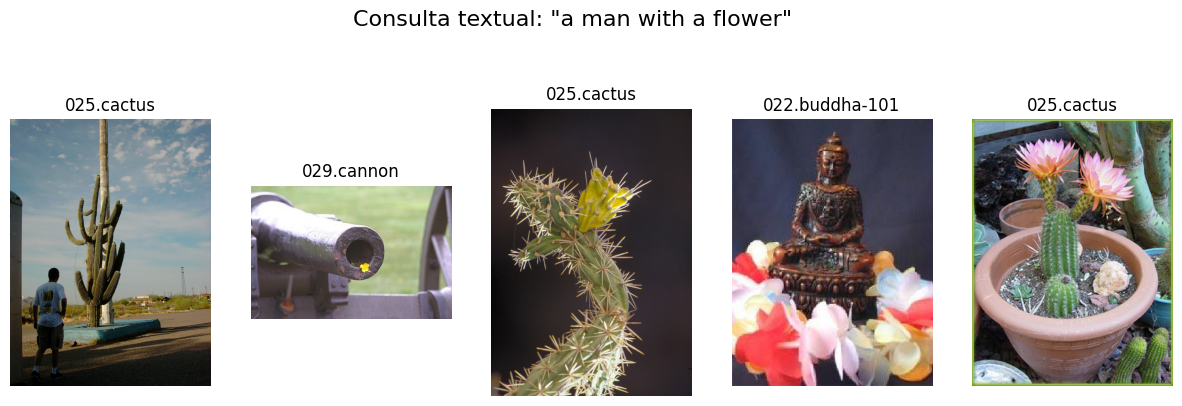

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    img = Image.open(rutas[idx])
    plt.subplot(1, top_k, i+1)
    plt.imshow(img)
    plt.title(f"{etiquetas[idx]}")
    plt.axis("off")

plt.suptitle(f"Consulta textual: \"{consulta}\"", fontsize=16)
plt.show()